In [7]:
import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers
from keras import losses


# 4 - Assignment Part 2

In [19]:
def mackey_glass(t, mg_dict, beta=0.2, gamma=0.1, n=10, r=25):
    if t == 0:
        return 1.5
    elif t < 0:
        return 0

    if mg_dict.get(t):
        return mg_dict.get(t)

    t_prev = t - 1

    if not mg_dict.get(t_prev):
        mg_dict[t_prev] = mackey_glass(t_prev, mg_dict)

    mg_t = mg_dict.get(t_prev)

    if not mg_dict.get(t_prev - r):
        mg_dict[t_prev - r] = mackey_glass(t_prev - r, mg_dict)

    mg_tr = mg_dict.get(t_prev - r)

    return mg_t + (beta * mg_tr) / (1 + mg_tr ** n) - gamma * mg_t

mg_dict = {}
input = []
output = []
for t in range(300, 1500):
    input.append([mackey_glass(t-20, mg_dict), mackey_glass(t-15, mg_dict), mackey_glass(t-10, mg_dict), mackey_glass(t-5, mg_dict), mackey_glass(t, mg_dict)])
    output.append(mackey_glass(t+5, mg_dict))

input = np.array(input)
output = np.array(output)


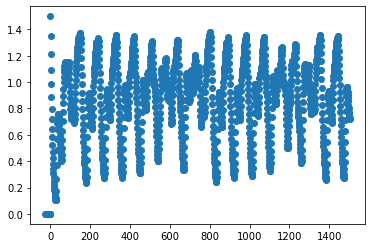

In [20]:
plt.scatter(mg_dict.keys(), mg_dict.values())
plt.show()

In [21]:
# consecutive blocks of the time series: train -> val -> test
X_train_val, X_test, y_train_val, y_test = train_test_split(input, output, test_size=200, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)


In [52]:
def create_network(hidden_layer_nodes=[9], activation=activations.sigmoid, final_activation=activations.linear, input_shape=5, output_shape=1):
    model = Sequential()
    for i, nodes in enumerate(hidden_layer_nodes):
        if i == 0:
            print("New input layer:", "input_shape", input_shape, "nodes", nodes)
            model.add(Dense(nodes, input_dim=input_shape, activation=activation))
        else:
            print("New hidden layer:", "nodes", nodes)
            model.add(Dense(nodes, activation=activation))
    print("New output layer:", "output_shape", output_shape)
    model.add(Dense(output_shape, activation=final_activation))
    return model


model = create_network()
model.compile(loss=losses.mean_squared_error, optimizer="sgd", metrics=['mse'])
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=0, callbacks=es)

_, accuracy = model.evaluate(X_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))


New input layer: input_shape 5 nodes 9
New output layer: output_shape 1
Epoch 1/500
25/25 [==============================] - 0s 6ms/step - loss: 0.4431 - mse: 0.4431 - val_loss: 0.1027 - val_mse: 0.1027
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0979 - mse: 0.0979 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - mse: 0.0837 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - mse: 0.0820 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 8/500

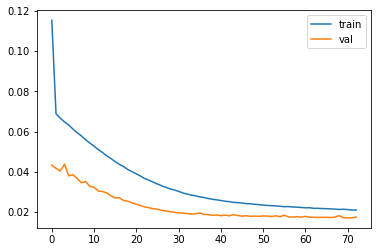

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()